In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import matplotlib.dates as mdates

In [2]:
filenames = ['arda_201001', 'arda_201201', 'arda_210301', 'arda_210512',
             'arda_220127',
            'arda_220522', 'arda_220612', 'arda_220816', 
             'arda_221130', 'arda_230220', 'arda_230312', 'arda_230411',
             'arda_230606', 'arda_230911', 'arda_231018', 'arda_240120', 'arda_240328',
             'arda_backpage_210125', 'arda_backpage_210422', 
             'arda_backpage_210624', 'arda_backpage_210726', 
             'arda_backpage_210925', 'arda_backpage_211016', 
             'arda_journal_php_201001', 
             'arda_publication_180107', 
             'arda_publication_180818', 
             'arda_publication_190102', 
             'arda_publication_190705']

dates = ['October 1, 2020', 'December 1, 2020', 'March 1, 2021', 'May 12, 2021', 
         'January 27, 2022', 
         'May 22, 2022', 'June 12, 2022', 'August 16, 2022', 
         'November 30, 2022', 'February 20, 2023', 'March 13, 2023', 'April 11, 2023',
         'June 6, 2023', 'September 11, 2023', 'October 18, 2023', 'January 20, 2024', 'March 28, 2024',
        'Jan 25, 2021', 'April 22, 2021', 
         'June 24, 2021', 'July 26, 2021', 
         'September 25, 2021', 'October 16, 2021', 'October 1, 2020',
         'January 7, 2018', 
         'August 18, 2018', 
         'January 1, 2019',
         'July 5, 2019'
        ]

urls = ['www.ardaconference.com/journals-publication.php',
        'www.ardaconference.com/journals/',
       'https://www.ardaconference.com/journal.php', 
        'http://ardaconference.com/publication.php']

crawl_urls = [urls[0], urls[0], urls[0], urls[0],
              urls[1], 
             urls[1], urls[1], urls[1],
            urls[1], urls[1], urls[1], urls[1],
              urls[1], urls[1], urls[1], urls[1], urls[1],
            urls[2], urls[2], urls[2],
            urls[2], urls[2], urls[2], urls[2], 
              urls[3], urls[3], urls[3], urls[3]]

arda_df_array = []

for filename, date, crawl_url in zip(filenames, dates, crawl_urls):
    arda_df = pd.read_csv('~/OneDrive - Northwestern University/aging_paper_mills/materials/general/manually_curated/' + filename + '.csv',
                          encoding='latin')
    arda_df['crawl_date'] = date
    arda_df['crawl_url'] = crawl_url
    arda_df['filename'] = filename
    arda_df_array.append(arda_df)
    
arda_df = pd.concat(arda_df_array)

In [3]:
arda_df = arda_df[['Journal', 'ISSN', 'Publisher', 'Indexed', 
         'crawl_date', 'crawl_url', 'filename',
       'Plagiarism', 'Duration', 'Link', 'Topics']]

In [4]:
arda_df.loc[arda_df['Journal'] == 'Key Engineering Materials \x96 Q3', 'Journal'] = 'Key Engineering Materials'

In [5]:
arda_df['issn'] = arda_df['ISSN'].str.split('/')

In [6]:
arda_df = arda_df.explode('issn')

In [7]:
arda_df['crawl_date'] = pd.to_datetime(arda_df['crawl_date'])

In [8]:
arda_df.groupby('issn').nunique()['crawl_date'].sort_values()

issn
1323-6903     1
1757-899X     1
1800-6450     1
1827-7160     1
1013-9826     1
             ..
2394-6849    23
2394-2320    23
2373-7972    23
2332-2144    23
2332-1121    23
Name: crawl_date, Length: 217, dtype: int64

In [9]:
issn_sets = arda_df.groupby('Journal')['issn'].apply(set).values

issn_to_uid_dict = {}

count = 0
for issn_set in issn_sets:
    for issn in issn_set:
        issn_to_uid_dict[issn] = count
    count += 1

In [10]:
issn_to_uid_dict

{'2372-0352': 0,
 '2372-0484': 2,
 '2375-1576': 3,
 '2471-1888': 4,
 '2373-7972': 5,
 '2327-8994': 6,
 '0094-243X': 7,
 '2300-5599': 8,
 '2519-4445': 9,
 '1857-8365': 12,
 '2194-5357': 11,
 '2332-0044': 13,
 '2332-0036': 13,
 '2587-2249': 14,
 '2277-9205': 15,
 '1583-6258': 16,
 '2230-5807': 17,
 '0975-1130': 18,
 '2237-8960': 19,
 '2304-7232': 20,
 '2588-4344': 21,
 '2288-601X': 22,
 '2332-1121': 24,
 '0034-7418': 25,
 '2582-7464': 26,
 '0011-9342': 27,
 '2281-4876': 28,
 '1110-8703': 29,
 '2090-0740': 30,
 '1681-8997': 31,
 '2331-6268': 32,
 '2331-625X': 32,
 '2676-6280': 33,
 '2063-5346': 34,
 '2323-5233': 35,
 '2515-8260': 36,
 '1812-9269': 37,
 '2331-5156': 38,
 '2331-513X': 38,
 '2308-4057': 40,
 '1474-7359': 41,
 '2394-4196 ': 42,
 '2350-0921': 42,
 '2348-7437': 43,
 '0973-9130': 44,
 '1520-5045': 46,
 '0970-2555': 47,
 '2203-1731': 48,
 '1521-4672': 49,
 '1800-6450': 50,
 '1800-7473': 50,
 '2277-7970': 51,
 '2249-7277': 51,
 '0976-6480': 52,
 '0976-6499': 52,
 '2207-6360': 53,


In [11]:
arda_df['uid'] = arda_df['issn'].apply(lambda x: issn_to_uid_dict.get(x))

In [12]:
arda_df.to_csv('../data/arda_timeline_240416.csv', index=False)

Save progress

Check for hijacked

In [13]:
rw_hijacked = pd.read_csv('../data/240301_retraction_watch_hijacked_journal.csv', header=1, index_col=0)

In [14]:
hijacked_issn = rw_hijacked['ISSN (Hijacked)'].apply(lambda x: str(x).split(', ')).explode()
orig_issn = rw_hijacked['ISSN (Original)'].apply(lambda x: str(x).split(', ')).explode()

In [15]:
arda_df[arda_df['ISSN'].isin(hijacked_issn) | arda_df['ISSN'].isin(orig_issn)]\
['ISSN'].apply(lambda x: issn_to_uid_dict.get(x)).nunique()

17

In [16]:
arda_df[arda_df['ISSN'].isin(hijacked_issn) | arda_df['ISSN'].isin(orig_issn)].drop_duplicates('Journal')

,Journal,ISSN,Publisher,Indexed,crawl_date,crawl_url,filename,Plagiarism,Duration,Link,Topics,issn,uid
0,Test engineering and management (TEST),0193-4120,Matingley,Scopus,2020-10-01,www.ardaconference.com/journals-publication.php,arda_201001,NaN,NaN,NaN,NaN,0193-4120,191
16,International Journal of Advanced Science and ...,2207-6360,Scopus,NaN,2020-10-01,www.ardaconference.com/journals-publication.php,arda_201001,NaN,NaN,NaN,NaN,2207-6360,53
18,International Journal of Disaster Recovery and...,2207-8363,Web of Science,SERSC,2020-10-01,www.ardaconference.com/journals-publication.php,arda_201001,NaN,NaN,NaN,NaN,2207-8363,63
23,Parishod Journal,2347-6648,NaN,UGC,2020-10-01,www.ardaconference.com/journals-publication.php,arda_201001,NaN,NaN,NaN,NaN,2347-6648,151
21,Journal of Chemical Health Risks,2251-6719,NaN,Scopus,2022-01-27,www.ardaconference.com/journals/,arda_220127,Below 25%,"15-20 days for Review process, after acceptanc...",https://www.scopus.com/sourceid/21100912214,"Toxicology, Mineral and Organic Agents, Enviro...",2251-6719,106
1,Specialusis Ugdymas/ Special Education - Q4,1392-5369,NaN,"Scopus, Scimago",2022-05-22,www.ardaconference.com/journals/,arda_220522,Less than 25%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100223584,All Departments; Psychology (Developmental and...,1392-5369,170
38,Telematique (Telecommunications),1856-4194,NaN,ESCI-Web of Science,2022-11-30,www.ardaconference.com/journals/,arda_221130,Less than 25%,Acceptance within 4 days and publication withi...,https://tinyurl.com/d5evx456,All research domains,1856-4194,190
42,BIOGECKO,2230-5807,NaN,ESCI-Web of Science,2023-03-13,www.ardaconference.com/journals/,arda_230312,Less than 25%,Acceptance within 2 days and publication withi...,https://tinyurl.com/2p27pt7y,All Departments,2230-5807,17
40,The Ciência and Engenharia - Science and Engin...,0103-944X,NaN,UGC Care List,2023-04-11,www.ardaconference.com/journals/,arda_230411,Less than 20%,Acceptance within 2 days and publication withi...,https://ugccare.unipune.ac.in/Apps1/User/LR/Lo...,All departments,0103-944X,192
41,LAMPYRID,2041-4900,NaN,ESCI-Web of Science,2023-06-06,www.ardaconference.com/journals/,arda_230606,Less than 25%,Acceptance within 2 days and publication withi...,http://surl.li/gxqdq,NaN,2041-4900,134


# Main figure

In [2]:
arda_df = pd.read_csv('../data/arda_timeline_240416.csv')

In [3]:
arda_df['crawl_date'] = pd.to_datetime(arda_df['crawl_date'])

In [4]:
scopus_deindexed = pd.read_csv('~/OneDrive - Northwestern University/aging_paper_mills/materials/general/manually_curated/' + \
            'scopus_discontinued_240301.csv',
                          encoding='latin', header=1)
scopus_indexed = pd.read_csv('~/OneDrive - Northwestern University/aging_paper_mills/materials/general/manually_curated/' + \
            'indexed_by_scopus_240301.csv',
                          encoding='latin', header=0)
scopus_indexed['Print-ISSN'] = scopus_indexed['Print-ISSN'].astype(str).apply(lambda x:x[0:4] + '-' + x[4:])
scopus_indexed['E-ISSN'] = scopus_indexed['E-ISSN'].astype(str).apply(lambda x:x[0:4] + '-' + x[4:])
scopus_deindexed['Print ISSN'] = scopus_deindexed['Print ISSN'].astype(str).apply(lambda x:x[0:4] + '-' + x[4:])
scopus_deindexed['EISSN'] = scopus_deindexed['EISSN'].astype(str).apply(lambda x:x[0:4] + '-' + x[4:])

wos_indexed = pd.read_csv('~/OneDrive - Northwestern University/aging_paper_mills/materials/LICENSED/from_clarivate_230224/' + \
            'WoS_Core_Journal_History_2021_unfiltered.csv',
                          encoding='latin', header=0)

In [5]:
pubmed_df = pd.read_parquet('~/OneDrive - Northwestern University/aging_paper_mills/materials/general/manually_curated/' + \
                'nlm_results_parsed_230419.parquet')

pubmed_df = pubmed_df.explode('pubmed').explode('medline')

new_pubmed_values = []
for pubmed_list in pubmed_df['pubmed'].values:
    if type(pubmed_list) == list:
        if pubmed_list[1].endswith('-'):
            pubmed_list[1] = 'current'
    new_pubmed_values.append(pubmed_list)
    
pubmed_df['pubmed'] = new_pubmed_values

new_pubmed_values = []
for pubmed_list in pubmed_df['medline'].values:
    if type(pubmed_list) == list:
        if pubmed_list[1].endswith('-'):
            pubmed_list[1] = 'current'
    new_pubmed_values.append(pubmed_list)
    
pubmed_df['medline'] = new_pubmed_values

pubmed_df[pubmed_df['title'] == ' Computational intelligence and neuroscience.']

pubmed_df = pubmed_df.explode('pubmed').explode('medline')#.explode('medline').explode('medline')

pubmed_df['issn'] = pubmed_df['issn'].apply(lambda x: x.split(';'))
pubmed_df = pubmed_df.explode('issn')

pubmed_df['issn'] = pubmed_df['issn'].str.strip()

pubmed_df['issn'] = pubmed_df['issn'].apply(lambda x: x.split('(')[0].upper())

pubmed_df['title'] = pubmed_df['title'].str.rstrip('.').str.strip()

pubmed_titles = pubmed_df['title']
pubmed_issns = pubmed_df['issn']

#truth_series_0 = np.array([(x[-1] == '-') for x in pubmed_df['pubmed'].values.astype(str)])
#truth_series_1 = np.array([(x[-1] == '-') for x in pubmed_df['medline'].values.astype(str)])

pubmed_df['pubmed'] = pubmed_df['pubmed'].str.strip('-').replace({'current':'10000'})
pubmed_df['medline'] = pubmed_df['medline'].str.strip('-').replace({'current':'10000'})
pubmed_df['pubmed'] = pubmed_df['pubmed'].astype(float)
pubmed_df['medline'] = pubmed_df['medline'].astype(float)

#pubmed_df = pubmed_df[~truth_series_0 & ~truth_series_1].dropna(subset=['pubmed', 'medline']).groupby('issn').max().reset_index()
pubmed_df = pubmed_df.dropna(subset=['pubmed', 'medline']).groupby('issn').max().reset_index()

pubmed_df['last_year'] = np.max(pubmed_df[['pubmed', 'medline']], axis=1)

pubmed_df = pubmed_df[pubmed_df['issn'] != ''].copy()
pubmed_df['last_year'] = pubmed_df['last_year'].replace({10000:np.nan})

In [6]:
arda_df['scopus'] = arda_df['issn'].isin(scopus_indexed['Print-ISSN']) | arda_df['issn'].isin(scopus_indexed['E-ISSN'])
arda_df['wos'] = arda_df['issn'].isin(wos_indexed['ISSN']) | arda_df['issn'].isin(wos_indexed['EISSN'])
arda_df['pubmed'] = arda_df['issn'].isin(pubmed_df['issn'])

In [7]:
scopus_deindexed_0 = pd.merge(scopus_deindexed, 
                            arda_df.drop_duplicates(['uid', 'issn']), 
                            left_on='Print ISSN', 
                            right_on='issn')
scopus_deindexed_1 = pd.merge(scopus_deindexed, 
                            arda_df.drop_duplicates(['uid', 'issn']), 
                            left_on='EISSN', 
                            right_on='issn')
scopus_deindexed = pd.concat([scopus_deindexed_0, scopus_deindexed_1])

In [8]:
scopus_deindexed = scopus_deindexed.sort_values('Year', ascending=False).drop_duplicates(['uid', 'Sourcerecord ID'], keep='first')

In [9]:
scopus_deindexed['scopus_last_year'] = scopus_deindexed['Year']

In [10]:
wos_deindexed = wos_indexed[wos_indexed['Active'] == 'No']

In [11]:
wos_deindexed_0 = pd.merge(wos_deindexed, 
                            arda_df.drop_duplicates(['uid', 'issn']), 
                            left_on='ISSN', 
                            right_on='issn')
wos_deindexed_1 = pd.merge(wos_deindexed, 
                            arda_df.drop_duplicates(['uid', 'issn']), 
                            left_on='EISSN', 
                            right_on='issn')
wos_deindexed = pd.concat([wos_deindexed_0, wos_deindexed_1])

In [12]:
wos_deindexed['years'] = wos_deindexed[['SCIE', 'SSCI', 'AHCI',
       'ESCI']].fillna('').sum(axis=1)

In [13]:
wos_deindexed['wos_last_year'] = wos_deindexed['years'].apply(lambda x: int(x.split('-')[-1]))

In [14]:
pubmed_deindexed = pd.merge(pubmed_df, arda_df.drop_duplicates(['uid', 'issn']), on='issn')

In [15]:
uid_df = pd.DataFrame(index=np.unique(arda_df['uid']))

In [16]:
uid_df['earliest_crawl'] = arda_df.groupby('uid').min()['crawl_date']
uid_df['latest_crawl'] = arda_df.groupby('uid').max()['crawl_date']
uid_df['scopus'] = arda_df.groupby('uid').max()['scopus']
uid_df['wos'] = arda_df.groupby('uid').max()['wos']
uid_df['pubmed'] = arda_df.groupby('uid').max()['pubmed']
uid_df['scopus_last_year'] = scopus_deindexed.groupby('uid').max()['scopus_last_year']
uid_df['wos_last_year'] = wos_deindexed.groupby('uid').max()['wos_last_year']

C:\Users\richa\AppData\Local\Temp\ipykernel_9160\2227429504.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  uid_df['earliest_crawl'] = arda_df.groupby('uid').min()['crawl_date']
C:\Users\richa\AppData\Local\Temp\ipykernel_9160\2227429504.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  uid_df['latest_crawl'] = arda_df.groupby('uid').max()['crawl_date']
C:\Users\richa\AppData\Local\Temp\ipykernel_9160\2227429504.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  uid_df['scopus'] = arda_df.grou

In [17]:
arda_df = arda_df.drop_duplicates(['uid', 'crawl_date']).sort_values('crawl_date')

In [18]:
uid_df[['scopus', 'wos']] = uid_df[['scopus', 'wos']].fillna(False)

In [19]:
uid_df.loc[~uid_df['wos_last_year'].isna(), 'wos'] = True

In [20]:
uid_df['scopus_last_year'] = uid_df['scopus_last_year'].astype(float)

In [21]:
uid_df.loc[(uid_df['wos_last_year'] <= 2017), 'wos'] = False
uid_df.loc[(uid_df['scopus_last_year'] <= 2017), 'scopus'] = False

In [22]:
uid_df['both'] = uid_df['scopus'] & uid_df['wos']

In [23]:
uid_df['color'] = 'dimgrey'
uid_df.loc[uid_df['scopus'], 'color'] = 'orange'
uid_df.loc[uid_df['wos'], 'color'] = 'darkblue'
uid_df.loc[uid_df['both'], 'color'] = 'seagreen'

# Check for Scopus-indexed ARDA-listed journals listed in 2020

In [24]:
cond_a = uid_df['earliest_crawl'] < pd.datetime(year=2021, month=1, day=1)
cond_b = uid_df['latest_crawl'] > pd.datetime(year=2019, month=12, day=31)
print(len(uid_df[cond_a & cond_b & uid_df['scopus']]))
print(len(uid_df[cond_a & cond_b & uid_df['scopus'] & (uid_df['scopus_last_year'] >= 2020)]))

39
13


C:\Users\richa\AppData\Local\Temp\ipykernel_9160\102705114.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  cond_a = uid_df['earliest_crawl'] < pd.datetime(year=2021, month=1, day=1)
C:\Users\richa\AppData\Local\Temp\ipykernel_9160\102705114.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  cond_b = uid_df['latest_crawl'] > pd.datetime(year=2019, month=12, day=31)


In [25]:
uids = uid_df.sort_values(['earliest_crawl', 'latest_crawl']).index.values

In [26]:
color_dict = dict(zip(uid_df.index.values, uid_df['color'].values))

uid_df_slice = uid_df.dropna(subset=['scopus_last_year'])
uid_df_slice = uid_df_slice[uid_df_slice['scopus'] == True]
scopus_deindex_dict = dict(zip(uid_df_slice.index.values, uid_df_slice['scopus_last_year'].values))

uid_df_slice = uid_df.dropna(subset=['wos_last_year'])
uid_df_slice = uid_df_slice[uid_df_slice['wos'] == True]
wos_deindex_dict = dict(zip(uid_df_slice.index.values, uid_df_slice['wos_last_year'].values))

In [27]:
crawl_date_dict = arda_df.drop_duplicates(['uid', 'crawl_date']).sort_values('crawl_date').groupby('uid')['crawl_date'].apply(list)

In [28]:
dates = arda_df['crawl_date'].unique()
n_journals = []
for date in arda_df['crawl_date'].unique():
    n_journals.append(np.sum((uid_df['earliest_crawl'] <= date) & (uid_df['latest_crawl'] >= date)))

<BarContainer object of 27 artists>

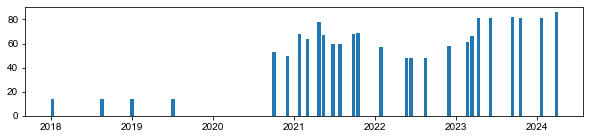

In [29]:
plt.figure(figsize=(10,2))
plt.bar(x=dates, height=n_journals, width=15.0)

In [30]:
uid_df.loc[164]

earliest_crawl      2021-10-16 00:00:00
latest_crawl        2024-03-28 00:00:00
scopus                             True
wos                               False
pubmed                            False
scopus_last_year                    NaN
wos_last_year                       NaN
both                              False
color                            orange
Name: 164, dtype: object

In [31]:
arda_df[arda_df['Journal'].str.contains('Militari')]

,Journal,ISSN,Publisher,Indexed,crawl_date,crawl_url,filename,Plagiarism,Duration,Link,Topics,issn,uid,scopus,wos,pubmed
461,Res Militaris,2265-6294,NaN,Scopus,2023-02-20,www.ardaconference.com/journals/,arda_230220,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
536,Res Militaris,2265-6294,NaN,Scopus,2023-03-13,www.ardaconference.com/journals/,arda_230312,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
614,Res Militaris,2265-6294,NaN,Scopus,2023-04-11,www.ardaconference.com/journals/,arda_230411,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
710,Res Militaris,2265-6294,NaN,Scopus,2023-06-06,www.ardaconference.com/journals/,arda_230606,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
806,Res Militaris,2265-6294,NaN,Scopus,2023-09-11,www.ardaconference.com/journals/,arda_230911,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False


In [32]:
n_journals

[14,
 14,
 14,
 14,
 53,
 50,
 68,
 64,
 78,
 67,
 60,
 60,
 68,
 69,
 57,
 48,
 48,
 48,
 58,
 61,
 66,
 81,
 81,
 82,
 81,
 81,
 86]

In [33]:
import datetime as dt

C:\Users\richa\AppData\Local\Temp\ipykernel_9160\3610879873.py:28: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  deindex_date = pd.datetime(day=1, month=1, year=int(scopus_deindex_dict.get(uid)))
C:\Users\richa\AppData\Local\Temp\ipykernel_9160\3610879873.py:29: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.scatter(pd.datetime(day=1, month=1, year=int(scopus_deindex_dict.get(uid))),
C:\Users\richa\AppData\Local\Temp\ipykernel_9160\3610879873.py:33: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  deindex_date = pd.datetime(day=1, month=1, year=int(wos_deindex_dict.get(uid)))
C:\Users\richa\AppData\Local\Temp\ipykernel_9160\3610879873.py:34: FutureWarning: The pandas.datetime class is dep

Text(0.06, 0.75, 'b')

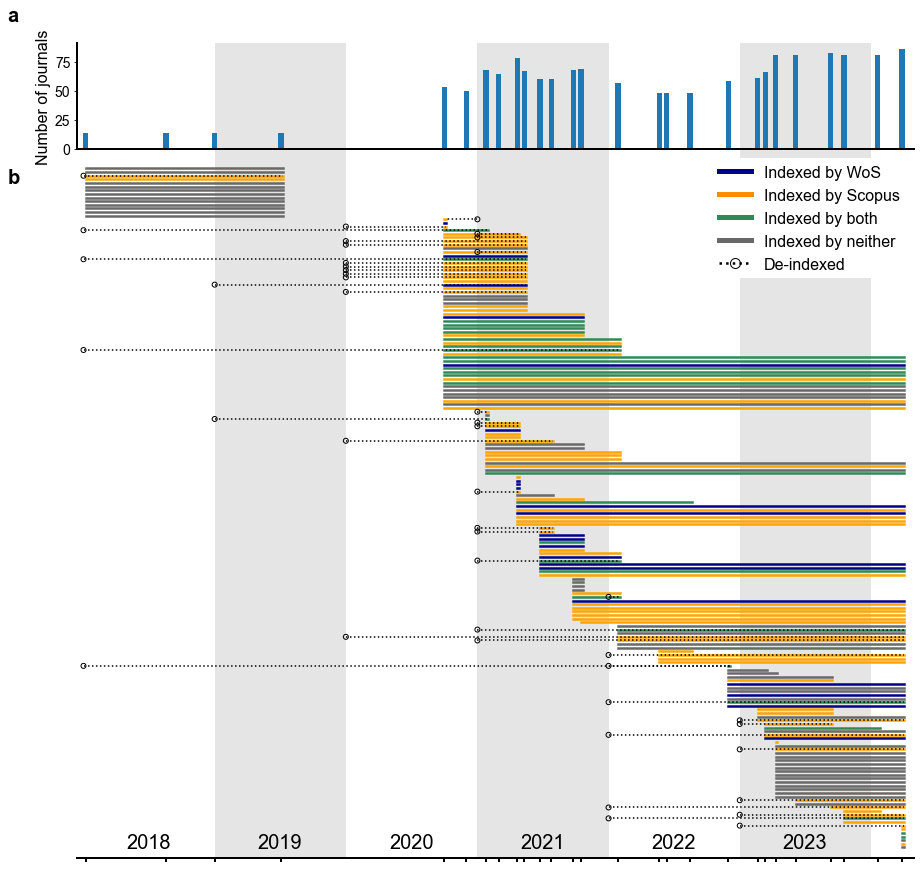

In [34]:
fig, axes = plt.subplots(figsize=(15,15), nrows=2, ncols=1, gridspec_kw={'height_ratios':[0.15,1], 'hspace':0.003})

linewidth = 2
# count of journals barplot
ax = axes[0]
ax.bar(x=dates, height=n_journals, width=15.0, align='center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]
ax.tick_params(labelsize=14, axis='both')
ax.set_xticks([])
ax.set_yticks(ticks=[0,25,50,75], labels=[0,25,50,75])
ax.set_ylim([0,91])
ax.set_ylabel('Number of journals', fontsize=16)

# journal continuity plot
ax = axes[1]

count = 0
for uid in uids:
    crawl_dates = crawl_date_dict.get(uid)
    crawl_dates = crawl_dates + [dt.timedelta(days=5) + crawl_dates[-1]]
    #print(len(crawl_dates))
    color = color_dict.get(uid)
    plt.plot(crawl_dates, [count]*len(crawl_dates), marker=None, markersize=2, color=color, linewidth=2.5)
    if uid in list(scopus_deindex_dict.keys()):
        deindex_date = pd.datetime(day=1, month=1, year=int(scopus_deindex_dict.get(uid)))
        plt.scatter(pd.datetime(day=1, month=1, year=int(scopus_deindex_dict.get(uid))), 
                    count, zorder=10, marker='o', facecolor='none', linewidth=1, edgecolors='k', s=25)
        plt.plot([deindex_date, crawl_dates[-1]], [count]*2, color='k', linewidth=1.5, linestyle='dotted')
    if uid in list(wos_deindex_dict.keys()):
        deindex_date = pd.datetime(day=1, month=1, year=int(wos_deindex_dict.get(uid)))
        plt.scatter(pd.datetime(day=1, month=1, year=int(wos_deindex_dict.get(uid))), 
                    count, zorder=10, marker='o', facecolor='none', linewidth=1, edgecolors='k', s=25)
        plt.plot([deindex_date, crawl_dates[-1]], [count]*2, color='k', linewidth=1.5, linestyle='dotted')
    count += 1
    
ax.set_ylim([2+len(uids), -5])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
[ax.spines[i].set_linewidth(linewidth) for i in ax.spines]
ax.tick_params(labelsize=14, axis='both', width=2)
ax.set_yticks([])

ax.set_xticks(dates)
#dates[(dates == dates[8]) | (dates == dates[15]) | (dates == dates[19]) | (dates == dates[20])] = ''
#ax.set_xticklabels(dates, rotation = 90)
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_xticklabels([])
ax.tick_params(axis='x', width=2)

#ax.text(s='2020', x=pd.to_datetime('Nov 1, 2020'), y=len(uids)+10, va='top', ha='center', fontsize=20)
ax.text(s='2018', x=pd.to_datetime('Jul 2, 2018'), y=len(uids)-5, va='top', ha='center', fontsize=20)
ax.text(s='2019', x=pd.to_datetime('Jul 2, 2019'), y=len(uids)-5, va='top', ha='center', fontsize=20)
ax.text(s='2020', x=pd.to_datetime('Jul 2, 2020'), y=len(uids)-5, va='top', ha='center', fontsize=20)
ax.text(s='2021', x=pd.to_datetime('Jul 2, 2021'), y=len(uids)-5, va='top', ha='center', fontsize=20)
ax.text(s='2022', x=pd.to_datetime('Jul 2, 2022'), y=len(uids)-5, va='top', ha='center', fontsize=20)
ax.text(s='2023', x=pd.to_datetime('Jul 2, 2023'), y=len(uids)-5, va='top', ha='center', fontsize=20)
#ax.text(s='2023', x=pd.to_datetime('Feb 15, 2023'), y=len(uids)+10, va='top', ha='center', fontsize=20)

for ax in axes:
    ax.fill_between(x=[pd.to_datetime('Jan 1, 2019'), pd.to_datetime('Jan 1, 2020')], 
                    y1=-1_000, y2=1_000, zorder=-1, color='k', alpha=0.1, linewidth=0)
    ax.fill_between(x=[pd.to_datetime('Jan 1, 2021'), pd.to_datetime('Jan 1, 2022')], 
                    y1=-1_000, y2=1_000, zorder=-1, color='k', alpha=0.1, linewidth=0)
    ax.fill_between(x=[pd.to_datetime('Jan 1, 2023'), pd.to_datetime('Jan 1, 2024')], 
                    y1=-1_000, y2=1_000, zorder=-1, color='k', alpha=0.1, linewidth=0)
    ax.set_xlim([pd.to_datetime('Dec 15, 2017'), pd.to_datetime('May 1, 2024')])
    
ax.plot([], [], label='Indexed by WoS', marker=None, color='darkblue', linewidth=5)
ax.plot([], [], label='Indexed by Scopus', marker=None, color='darkorange', linewidth=5)
ax.plot([], [], label='Indexed by both', marker=None, color='seagreen', linewidth=5)
ax.plot([], [], label='Indexed by neither', marker=None, color='dimgrey', linewidth=5)

ax.plot([], [], label='De-indexed', zorder=10, marker='o', markerfacecolor='none', markeredgewidth=1, color='k', 
        linestyle='dotted', linewidth=2.5, markersize=10)
leg = ax.legend(fontsize=16, frameon=True, bbox_to_anchor=(1,1), loc='upper right', framealpha=1)
leg.get_frame().set_linewidth(0)
 
fig.text(s='a', x=0.06, y=0.9, fontsize=20, weight='bold')
fig.text(s='b', x=0.06, y=0.75, fontsize=20, weight='bold')

#plt.savefig('../img/arda_timeline_240416.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/arda_timeline_240416.pdf', bbox_inches='tight')

In [50]:
dates[(dates == dates[8]) | (dates == dates[15]) | (dates == dates[19]) | (dates == dates[20])] = ''

In [51]:
dates

array(['2018-01-07T00:00:00.000000000', '2018-08-18T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-07-05T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2021-01-25T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
                                 'NaT', '2021-05-12T00:00:00.000000000',
       '2021-06-24T00:00:00.000000000', '2021-07-26T00:00:00.000000000',
       '2021-09-25T00:00:00.000000000', '2021-10-16T00:00:00.000000000',
       '2022-01-27T00:00:00.000000000',                           'NaT',
       '2022-06-12T00:00:00.000000000', '2022-08-16T00:00:00.000000000',
       '2022-11-30T00:00:00.000000000',                           'NaT',
                                 'NaT', '2023-04-11T00:00:00.000000000',
       '2023-06-06T00:00:00.000000000', '2023-09-11T00:00:00.000000000',
       '2023-10-18T00:00:00.000000000', '2024-01-20T00:00:00.000000000',
       '2024-03-28T00:00:00.000000000'], dtype='dat

In [52]:
arda_df[arda_df['Journal'].str.contains('Res M')]

,Journal,ISSN,Publisher,Indexed,crawl_date,crawl_url,filename,Plagiarism,Duration,Link,Topics,issn,uid,scopus,wos,pubmed
461,Res Militaris,2265-6294,NaN,Scopus,2023-02-20,www.ardaconference.com/journals/,arda_230220,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
536,Res Militaris,2265-6294,NaN,Scopus,2023-03-13,www.ardaconference.com/journals/,arda_230312,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
614,Res Militaris,2265-6294,NaN,Scopus,2023-04-11,www.ardaconference.com/journals/,arda_230411,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
710,Res Militaris,2265-6294,NaN,Scopus,2023-06-06,www.ardaconference.com/journals/,arda_230606,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False
806,Res Militaris,2265-6294,NaN,Scopus,2023-09-11,www.ardaconference.com/journals/,arda_230911,Less than 20%,Acceptance within 2 days and publication withi...,https://www.scopus.com/sourceid/21100908447,"Social Sciences (Political Science, Internatio...",2265-6294,163,True,False,False


In [53]:
uid_df['scopus'].sum()

106

In [54]:
uid_df['wos'].sum()

51

In [55]:
uid_df['both'].sum()

29

In [56]:
uid_df['pubmed'].sum()

2

In [57]:
np.sum(~uid_df['scopus'] & ~uid_df['wos'] & ~uid_df['pubmed'])

60

In [58]:
uid_df

,earliest_crawl,latest_crawl,scopus,wos,pubmed,scopus_last_year,wos_last_year,both,color
0,2020-10-01,2024-03-28,True,True,False,NaN,NaN,True,seagreen
2,2020-10-01,2024-03-28,True,True,False,NaN,NaN,True,seagreen
3,2020-10-01,2024-03-28,False,True,False,NaN,NaN,False,darkblue
4,2020-10-01,2024-03-28,True,True,False,NaN,NaN,True,seagreen
5,2020-10-01,2024-03-28,True,True,False,NaN,NaN,True,seagreen
...,...,...,...,...,...,...,...,...,...
203,2020-10-01,2021-05-12,True,False,False,NaN,NaN,False,orange
204,2021-09-25,2024-03-28,True,False,False,NaN,NaN,False,orange
205,2021-09-25,2021-10-16,False,False,False,NaN,NaN,False,dimgrey
206,2021-09-25,2021-10-16,False,False,False,NaN,NaN,False,dimgrey


In [59]:
arda_df[arda_df['uid'].isin(uid_df[uid_df['both']].index)]['Journal'].value_counts()

AIMS Neuroscience - Q4                                               23
Eurasian Chemical Communications                                     22
AIMS Public Health                                                   20
AIMS Environmental Science                                           20
AIMS Microbiology                                                    20
AIMS Materials Science - Q3                                          19
Materiale Plastice - Q3                                              19
Foods and Raw Materials - Q3                                         16
International Journal of Early Childhood Special Education (Q4)      13
Brazilian Journal of Operations & Production Management              11
Journal of Pharmaceutical Negative Results - Q4                       9
International Journal for Quality Research - Q2                       8
Journal of Experimental Biology and Agricultural Sciences             7
Russian Law Journal                                             

In [60]:
crawl_dates + [dt.timedelta(days=1) + crawl_dates[-1]]

[Timestamp('2024-03-28 00:00:00'),
 Timestamp('2024-04-02 00:00:00'),
 Timestamp('2024-04-03 00:00:00')]

In [61]:
uid_df.dropna(subset=['wos_last_year'])

,earliest_crawl,latest_crawl,scopus,wos,pubmed,scopus_last_year,wos_last_year,both,color
37,2021-09-25,2024-03-28,True,False,True,NaN,2005.0,False,orange
102,2023-09-11,2024-03-28,True,False,False,2022.0,2004.0,False,orange
111,2020-10-01,2022-01-27,True,True,False,NaN,2018.0,True,seagreen
119,2020-10-01,2021-05-12,False,True,False,NaN,2019.0,False,darkblue
133,2021-01-25,2022-01-27,True,False,False,NaN,1998.0,False,orange
146,2022-11-30,2022-11-30,True,True,False,2022.0,2018.0,True,seagreen
166,2021-01-25,2021-01-25,True,True,False,NaN,2019.0,True,seagreen
169,2020-10-01,2021-01-25,True,True,False,NaN,2018.0,True,seagreen


In [62]:
len(wos_deindex_dict)

5

In [63]:
len(scopus_deindex_dict)

39

In [64]:
set(scopus_deindex_dict.keys()) & set(wos_deindex_dict.keys())

{146}

In [65]:
uid_df.loc[147]

earliest_crawl      2022-01-27 00:00:00
latest_crawl        2024-03-28 00:00:00
scopus                            False
wos                               False
pubmed                            False
scopus_last_year                    NaN
wos_last_year                       NaN
both                              False
color                           dimgrey
Name: 147, dtype: object

In [66]:
arda_df[arda_df['uid'] == 147]

,Journal,ISSN,Publisher,Indexed,crawl_date,crawl_url,filename,Plagiarism,Duration,Link,Topics,issn,uid,scopus,wos,pubmed
226,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2022-01-27,www.ardaconference.com/journals/,arda_220127,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
281,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2022-05-22,www.ardaconference.com/journals/,arda_220522,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
336,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2022-06-12,www.ardaconference.com/journals/,arda_220612,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
391,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2022-08-16,www.ardaconference.com/journals/,arda_220816,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
459,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2022-11-30,www.ardaconference.com/journals/,arda_221130,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
530,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2023-02-20,www.ardaconference.com/journals/,arda_230220,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
607,Neurocosm International Journal,2582-7480,NaN,Google Scholar,2023-03-13,www.ardaconference.com/journals/,arda_230312,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
689,Neurocosm International Journal,2582-7480,NaN,"oogle Scholar, Research bib, Academia & Member...",2023-04-11,www.ardaconference.com/journals/,arda_230411,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
784,Neurocosm International Journal,2582-7480,NaN,"oogle Scholar, Research bib, Academia & Member...",2023-06-06,www.ardaconference.com/journals/,arda_230606,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False
880,Neurocosm International Journal,2582-7480,NaN,"oogle Scholar, Research bib, Academia & Member...",2023-09-11,www.ardaconference.com/journals/,arda_230911,Below 25%,10 days for review process and 15 days for pub...,NaN,"Neurology, Brain & Spine Learning related arti...",2582-7480,147,False,False,False


In [67]:
 n_journals

[14,
 14,
 14,
 14,
 53,
 50,
 68,
 64,
 78,
 67,
 60,
 60,
 68,
 69,
 57,
 48,
 48,
 48,
 58,
 61,
 66,
 81,
 81,
 82,
 81,
 81,
 86]

In [68]:
summary_df = pd.merge(uid_df.reset_index().rename(columns={'index':'uid'}), 
                      arda_df.drop_duplicates('uid', keep='last'), how='left')

In [69]:
summary_df = summary_df[['Journal', 'uid', 'ISSN', 'earliest_crawl', 'latest_crawl', 'scopus', 'wos', 'pubmed', 'scopus_last_year', 'wos_last_year']]

In [70]:
summary_df.sort_values('ISSN')

,Journal,uid,ISSN,earliest_crawl,latest_crawl,scopus,wos,pubmed,scopus_last_year,wos_last_year
24,Design Engineering Toronto,27,0011-9342,2021-04-22,2021-04-22,True,False,False,NaN,NaN
127,Materiale Plastice - Q3,137,0025-5289,2021-01-25,2024-03-28,True,True,False,NaN,NaN
146,Psychology and Education,161,0033-3077,2021-01-25,2021-04-22,True,False,False,NaN,NaN
22,Colombian Journal of Chemical-Pharmaceutical S...,25,0034-7418,2021-09-25,2024-03-28,True,False,False,NaN,NaN
151,Revista de Chimie - Q2,166,0034-7752,2021-01-25,2021-01-25,True,True,False,NaN,2019.0
...,...,...,...,...,...,...,...,...,...,...
30,Eurasian Chemical Communications,33,2676-6280,2020-10-01,2024-03-28,True,True,False,NaN,NaN
117,Journal of Positive School Psychology (JPSP) - Q2,127,2717-7564,2022-11-30,2023-09-11,False,False,False,2020.0,NaN
68,International Journal of Environmental Problems,74,ISSN 2410-9339,2018-01-07,2019-07-05,False,False,False,NaN,NaN
34,NaN,37,NaN,2021-09-25,2024-03-28,True,False,True,NaN,2005.0


In [71]:
summary_df.loc[summary_df['uid'] == 37, 'Journal'] = 'Experimental Oncology'
summary_df.loc[summary_df['uid'] == 37, 'ISSN'] = '1812-9269'
summary_df.loc[summary_df['uid'] == 102, 'Journal'] = 'Journal of Advanced Zoology'
summary_df.loc[summary_df['uid'] == 102, 'ISSN'] = '0253-7214'
#summary_df.loc[summary_df['uid'] == 134, 'Journal'] = 'Key Engineering Materials - Q3'
#summary_df.loc[summary_df['uid'] == 134, 'ISSN'] = '1013-9826'

In [72]:
summary_df.to_csv('../data/240614_arda_summary_data.csv', index=False)